In [ ]:
# mostly copied from https://github.com/YBIGTA/facebigta/tree/master/PreProcessing

In [9]:
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import argparse 
import imutils
import dlib
import cv2
import os
import sys
import inspect
import matplotlib.pyplot as plt

In [10]:
from keras.models import Model
from keras.layers import Input, Activation, add, Dense, Flatten, Dropout
from keras.layers.convolutional import Conv2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2
from keras import backend as K

In [11]:
from pathlib import Path
import numpy as np
from keras.utils.data_utils import get_file

In [12]:
DATASET_NAME = 'kpop_profile'
ROOT_DIR = '/Users/jerry.chi/Documents/preprocess_face'
DATASET_DIR = f'{ROOT_DIR}/{DATASET_NAME}/'
PREDICTOR_PATH = ROOT_DIR + '/shape_predictor_68_face_landmarks.dat'
SOURCE_FOLDER = f'{DATASET_DIR}/raw' # images scraped using scrape_kpop_images.ipynb
DES_FOLDER = f'{DATASET_DIR}/raw'

In [4]:
# create folders if they don't exist
for dir_name in [f'{ROOT_DIR}/{DATASET_NAME}', SOURCE_FOLDER, DES_FOLDER]:
    try:
        os.mkdir(dir_name)
        os.chmod(dir_name, 0o777)
    except:
        pass

In [5]:
def get_gender(image=None, image_path=None):
    ''' adapted from: https://towardsdatascience.com/predict-age-and-gender-using-convolutional-neural-network-and-opencv-fd90390e3ce6
    '''
    MODEL_MEAN_VALUES = (78.4263377603, 87.7689143744, 114.895847746)
    #age_list = ['(0, 2)', '(4, 6)', '(8, 12)', '(15, 20)',                '(25, 32)', '(38, 43)', '(48, 53)', '(60, 100)']
    gender_list = ['Male', 'Female']

    #age_net = cv2.dnn.readNetFromCaffe('deploy_age.prototxt', 'age_net.caffemodel')
    gender_net = cv2.dnn.readNetFromCaffe(f'{ROOT_DIR}/deploy_gender.prototxt', f'{ROOT_DIR}/gender_net.caffemodel')
    
    face_cascade = cv2.CascadeClassifier(f'{ROOT_DIR}/haarcascade_frontalface_alt.xml')
    if image is None:
        image= cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)
    if (len(faces) > 0):
        print("Found {} faces".format(str(len(faces))))
    else:
        print('no faces found')
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (255, 255, 0), 2)
        # Get Face
        face_img = image[y:y + h, h:h + w].copy()
        cv2.imshow('tmp_image',face_img)
        plt.imshow(image,cmap='gray')
        plt.show()
        blob = cv2.dnn.blobFromImage(
            face_img, 1, (227, 227), MODEL_MEAN_VALUES, swapRB=False)
        # Predict Gender
        gender_net.setInput(blob)
        gender_preds = gender_net.forward()
        gender = gender_list[gender_preds[0].argmax()]
        print("Gender : " + gender)
        return gender_preds


Found 1 faces


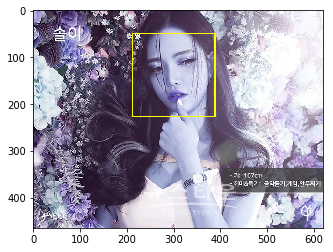

Gender : Male


In [6]:
res = get_gender(image_path=f'{DATASET_DIR}/raw/000023.jpg')

In [51]:
res

array([[0.82964176, 0.17035823]], dtype=float32)

In [13]:
sys.setrecursionlimit(2 ** 20)
np.random.seed(2 ** 10)
class WideResNet:
    def __init__(self, image_size, depth=16, k=8):
        self._depth = depth
        self._k = k
        self._dropout_probability = 0
        self._weight_decay = 0.0005
        self._use_bias = False
        self._weight_init = "he_normal"

        if K.image_dim_ordering() == "th":
            logging.debug("image_dim_ordering = 'th'")
            self._channel_axis = 1
            self._input_shape = (3, image_size, image_size)
        else:
            logging.debug("image_dim_ordering = 'tf'")
            self._channel_axis = -1
            self._input_shape = (image_size, image_size, 3)

    # Wide residual network http://arxiv.org/abs/1605.07146
    def _wide_basic(self, n_input_plane, n_output_plane, stride):
        def f(net):
            # format of conv_params:
            #               [ [kernel_size=("kernel width", "kernel height"),
            #               strides="(stride_vertical,stride_horizontal)",
            #               padding="same" or "valid"] ]
            # B(3,3): orignal <<basic>> block
            conv_params = [[3, 3, stride, "same"],
                           [3, 3, (1, 1), "same"]]

            n_bottleneck_plane = n_output_plane

            # Residual block
            for i, v in enumerate(conv_params):
                if i == 0:
                    if n_input_plane != n_output_plane:
                        net = BatchNormalization(axis=self._channel_axis)(net)
                        net = Activation("relu")(net)
                        convs = net
                    else:
                        convs = BatchNormalization(axis=self._channel_axis)(net)
                        convs = Activation("relu")(convs)

                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)
                else:
                    convs = BatchNormalization(axis=self._channel_axis)(convs)
                    convs = Activation("relu")(convs)
                    if self._dropout_probability > 0:
                        convs = Dropout(self._dropout_probability)(convs)
                    convs = Conv2D(n_bottleneck_plane, kernel_size=(v[0], v[1]),
                                          strides=v[2],
                                          padding=v[3],
                                          kernel_initializer=self._weight_init,
                                          kernel_regularizer=l2(self._weight_decay),
                                          use_bias=self._use_bias)(convs)

            # Shortcut Connection: identity function or 1x1 convolutional
            #  (depends on difference between input & output shape - this
            #   corresponds to whether we are using the first block in each
            #   group; see _layer() ).
            if n_input_plane != n_output_plane:
                shortcut = Conv2D(n_output_plane, kernel_size=(1, 1),
                                         strides=stride,
                                         padding="same",
                                         kernel_initializer=self._weight_init,
                                         kernel_regularizer=l2(self._weight_decay),
                                         use_bias=self._use_bias)(net)
            else:
                shortcut = net

            return add([convs, shortcut])

        return f


    # "Stacking Residual Units on the same stage"
    def _layer(self, block, n_input_plane, n_output_plane, count, stride):
        def f(net):
            net = block(n_input_plane, n_output_plane, stride)(net)
            for i in range(2, int(count + 1)):
                net = block(n_output_plane, n_output_plane, stride=(1, 1))(net)
            return net

        return f

#    def create_model(self):
    def __call__(self):
        logging.debug("Creating model...")

        assert ((self._depth - 4) % 6 == 0)
        n = (self._depth - 4) / 6

        inputs = Input(shape=self._input_shape)

        n_stages = [16, 16 * self._k, 32 * self._k, 64 * self._k]

        conv1 = Conv2D(filters=n_stages[0], kernel_size=(3, 3),
                              strides=(1, 1),
                              padding="same",
                              kernel_initializer=self._weight_init,
                              kernel_regularizer=l2(self._weight_decay),
                              use_bias=self._use_bias)(inputs)  # "One conv at the beginning (spatial size: 32x32)"

        # Add wide residual blocks
        block_fn = self._wide_basic
        conv2 = self._layer(block_fn, n_input_plane=n_stages[0], n_output_plane=n_stages[1], count=n, stride=(1, 1))(conv1)
        conv3 = self._layer(block_fn, n_input_plane=n_stages[1], n_output_plane=n_stages[2], count=n, stride=(2, 2))(conv2)
        conv4 = self._layer(block_fn, n_input_plane=n_stages[2], n_output_plane=n_stages[3], count=n, stride=(2, 2))(conv3)
        batch_norm = BatchNormalization(axis=self._channel_axis)(conv4)
        relu = Activation("relu")(batch_norm)

        # Classifier block
        pool = AveragePooling2D(pool_size=(8, 8), strides=(1, 1), padding="same")(relu)
        flatten = Flatten()(pool)
        predictions_g = Dense(units=2, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                              kernel_regularizer=l2(self._weight_decay), activation="softmax",
                              name="pred_gender")(flatten)
        predictions_a = Dense(units=101, kernel_initializer=self._weight_init, use_bias=self._use_bias,
                              kernel_regularizer=l2(self._weight_decay), activation="softmax",
                              name="pred_age")(flatten)
        model = Model(inputs=inputs, outputs=[predictions_g, predictions_a])

        return model


In [14]:
pretrained_model = "https://github.com/yu4u/age-gender-estimation/releases/download/v0.5/weights.28-3.73.hdf5"
modhash = 'fbe63257a054c1c5466cfd7bf14646d6'

def get_args():
    parser = argparse.ArgumentParser(description="This script detects faces from web cam input, "
                                                 "and estimates age and gender for the detected faces.",
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.add_argument("--weight_file", type=str, default=None,
                        help="path to weight file (e.g. weights.28-3.73.hdf5)")
    parser.add_argument("--depth", type=int, default=16,
                        help="depth of network")
    parser.add_argument("--width", type=int, default=8,
                        help="width of network")
    parser.add_argument("--margin", type=float, default=0.4,
                        help="margin around detected face for age-gender estimation")
    parser.add_argument("--image_dir", type=str, default=None,
                        help="target image directory; if set, images in image_dir are used instead of webcam")
    args = parser.parse_args()
    return args


def yield_images_from_dir(image_dir):
    image_dir = Path(image_dir)

    for image_path in image_dir.glob("*.*"):
        img = cv2.imread(str(image_path), 1)

        if img is not None:
            h, w, _ = img.shape
            r = 640 / max(w, h)
            yield cv2.resize(img, (int(w * r), int(h * r)))


def get_gender_incep(image=None, image_path=None):
    args = get_args()
    #depth = args.depth
    depth=16
    #k = args.width
    k = 8
    #margin = args.margin
    margin = 0.4
    #image_dir = args.image_dir
    image_dir = DES_FOLDER

    if not weight_file:
        weight_file = get_file("weights.28-3.73.hdf5", pretrained_model, cache_subdir="pretrained_models",
                               file_hash=modhash, cache_dir=str(Path(__file__).resolve().parent))

    # for face detection
    detector = dlib.get_frontal_face_detector()

    # load model and weights
    img_size = 64
    model = WideResNet(img_size, depth=depth, k=k)()
    model.load_weights(weight_file)

    #image_generator = yield_images_from_dir(image_dir) if image_dir else yield_images()

    for img in image_generator:
        input_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_h, img_w, _ = np.shape(input_img)

        # detect faces using dlib detector
        detected = detector(input_img, 1)
        faces = np.empty((len(detected), img_size, img_size, 3))

        if len(detected) > 0:
            for i, d in enumerate(detected):
                x1, y1, x2, y2, w, h = d.left(), d.top(), d.right() + 1, d.bottom() + 1, d.width(), d.height()
                xw1 = max(int(x1 - margin * w), 0)
                yw1 = max(int(y1 - margin * h), 0)
                xw2 = min(int(x2 + margin * w), img_w - 1)
                yw2 = min(int(y2 + margin * h), img_h - 1)
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                # cv2.rectangle(img, (xw1, yw1), (xw2, yw2), (255, 0, 0), 2)
                faces[i, :, :, :] = cv2.resize(img[yw1:yw2 + 1, xw1:xw2 + 1, :], (img_size, img_size))

            # predict ages and genders of the detected faces
            results = model.predict(faces)
            predicted_genders = results[0]
            return predicted_genders

In [16]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(PREDICTOR_PATH)
fa = FaceAligner(predictor, desiredFaceWidth=100)

input_files = [os.path.join(dp,f) for dp, dn, fn in os.walk(os.path.expanduser(SOURCE_FOLDER)) for f in fn]
print("number of input files: {}".format(len(input_files)))

# loop over the face detections
for input_file in input_files:
        print('processing file: {}'.format(input_file))
        try:
                print(input_file)
                image = cv2.imread(input_file)
                height, width, channels = image.shape
                if (height < 300) or (width < 300):
                    print('image does not have high enough resolution. skipping this image.')
                    continue
                image = imutils.resize(image, width=800)
                gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                #des_path = '/'.join(['..',des_dir] + input_file.split("/")[2:-1])
                # show the original input image and detect faces in the grayscale
                # image
                rects = detector(gray, 1) # 1 is the num of times to upsample https://towardsdatascience.com/cnn-based-face-detector-from-dlib-c3696195e01c
                for rect_i, rect in enumerate(rects):
                        # extract the ROI of the *original* face, then align the face
                        # using facial landmarks
                        src_file_basename, src_file_ext = tuple(input_file.split("/")[-1].split('.'))
                        out_file = os.path.join(DES_FOLDER,f'{src_file_basename}_{rect_i}.{src_file_ext}')
                        try:
                                (x, y, w, h) = rect_to_bb(rect)
                                if (w < 100) or (h < 100):
                                    print('face does not have high enough resolution. skipping this face.')
                                    continue
                                faceOrig = imutils.resize(image[y:y + h, x:x + w], width=100)	
                                faceAligned = fa.align(image, gray, rect)
                                
                                # write to file
                                #               if os.path.isfile(out_file):
                                        #file_name = out_file.split("\\")[-1]
                                        #print(file_name.split(".")[0]+"0"+file_name.split(".")[1])
                                        #out_file = os.path.join(des_path, file_name.split(".")[0]+"(0)."+file_name.split(".")[-1])
                                cv2.imwrite(out_file,faceAligned)
                                print('wrote file: {}'.format(out_file))
                                #cv2.waitKey(0)
                                #print(out_file)
                        except:
                                print("CANNOT SAVE")
                                continue
        except:
                pass


number of input files: 24
processing file: /Users/jerry.chi/Documents/preprocess_face/.DS_Store
/Users/jerry.chi/Documents/preprocess_face/.DS_Store
processing file: /Users/jerry.chi/Documents/preprocess_face/shape_predictor_68_face_landmarks.dat
/Users/jerry.chi/Documents/preprocess_face/shape_predictor_68_face_landmarks.dat
processing file: /Users/jerry.chi/Documents/preprocess_face/kpop_profile/.DS_Store
/Users/jerry.chi/Documents/preprocess_face/kpop_profile/.DS_Store
processing file: /Users/jerry.chi/Documents/preprocess_face/kpop_profile/raw/000129.jpg
/Users/jerry.chi/Documents/preprocess_face/kpop_profile/raw/000129.jpg
image does not have high enough resolution. skipping this image.
processing file: /Users/jerry.chi/Documents/preprocess_face/kpop_profile/raw/000131.jpg
/Users/jerry.chi/Documents/preprocess_face/kpop_profile/raw/000131.jpg
wrote file: /Users/jerry.chi/Documents/preprocess_face/kpop_profile/processed/000131_0.jpg
processing file: /Users/jerry.chi/Documents/prepr